In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt 

# Load data
if True:
    img = np.arange(5*5, dtype=int).reshape(5,5)
    kernel = np.arange(9).reshape(3,3)
else:
    img = np.array(Image.open("./bird6.png"), dtype=int)
    img = img[:,:,0]

    kernel = np.array([[1,0,-1],
                       [2,0,-2],
                       [1,0,-1]], dtype=int)

nx, ny = img.shape


f_w, f_h = kernel.shape

res = np.zeros((nx,ny), dtype=int) # Same padding

# Numpy 버전

# Plain version

In [3]:
def left_rotate(arr, r):
    return np.roll(arr, -r)

imgarr = img.ravel()
left_rotate(imgarr, 1)

rotated = []
for i in range(f_w):
    for j in range(f_h):
        rotated.append(left_rotate(imgarr, (i -1)*nx + (j-1)))

nx, ny = 28,28
wx = 5
wy = 5
stride_x = 2
stride_y = 2

13^2 modified copies of img in convolution representaitons (14^2 아님?)
conv_img = []
for i in range(0, nx-wx+1, stride_x):
    for j in range(0, ny-wy+1, stride_y):
        conv_img.append()

### torch 

In [4]:
import torch

In [5]:
print(img, "\n\n", kernel)

[[ 0  1  2  3  4]
 [ 5  6  7  8  9]
 [10 11 12 13 14]
 [15 16 17 18 19]
 [20 21 22 23 24]] 

 [[0 1 2]
 [3 4 5]
 [6 7 8]]


In [6]:
nc = 1
def repeat_filter(kernel, n_repeat):
    return np.broadcast_to(kernel,(n_repeat,)+kernel.shape)
    
filters = repeat_filter(kernel, nc)

res_t = torch.conv2d(torch.tensor(img[np.newaxis, np.newaxis,:,:]), 
             torch.tensor(filters[np.newaxis,:,:,:]))

In [7]:
def annot_heatmap(ax, img):
    ax.imshow(img)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            text = ax.text(j, i, img[i, j],
                           ha="center", va="center", color="w")

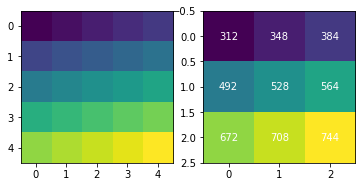

In [8]:
img_t = res_t.squeeze().numpy()

fig, axs = plt.subplots(1,2)

axs[0].imshow(img)
#axs[1].imshow(img_t)
annot_heatmap(axs[1], img_t)

plt.show()

In [9]:
import fase
from fase.core.seal_ckks import SEALContext

def rotate_input(img, kernel_size):
    assert img.ndim == 2
    nx, ny = img.shape
    imgarr = img.ravel()
    f_w, f_h = kernel_size
    
    rotated = []
    for i in range(f_w):
        for j in range(f_h):
            rotated.append(left_rotate(imgarr, (i -1)*nx + (j-1)))
    return rotated

In [10]:
rkernel = kernel.ravel()
for i, rr in enumerate(rotated):
    if i == 0:
        out = rr * rkernel[i]
    else:
        out += rr * rkernel[i]

In [11]:
rotated = rotate_input(img, (3,3))
mat_img = np.stack(rotated).T

out_mat = np.matmul(mat_img, kernel.ravel()) # 1024 x 9 * 9 x 1 -> 1024 x 1 
# 가운데 3x3은 맞고, 주변은 음...? 
# padding된 5x5 kernel로 곱해야하는 듯


res_t = torch.conv2d(torch.tensor(img[np.newaxis, np.newaxis,:,:]), 
             torch.tensor(filters[np.newaxis,:,:,:]), padding=1)
img_t = res_t.squeeze().numpy()

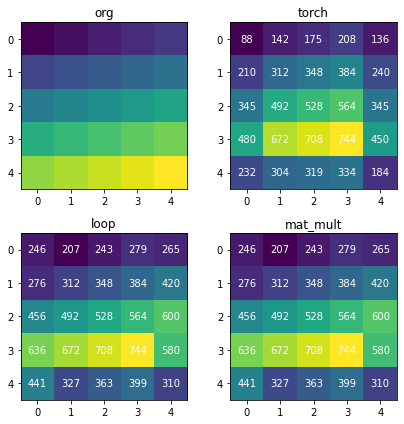

In [14]:
fig, axs = plt.subplots(2,2)
fig.set_size_inches(6,6)
axs = axs.ravel()

axs[0].imshow(img)
annot_heatmap(axs[1], img_t)
annot_heatmap(axs[2], out.reshape(nx, ny))
annot_heatmap(axs[3], out_mat.reshape(nx, ny))

axs[0].set_title("org")
axs[1].set_title("torch")
axs[2].set_title("loop")
axs[3].set_title("mat_mult")

plt.tight_layout()
plt.show()

나는 padding이 안 되고 뭘 한거임? 

### GAELLE


- kernel size는 홀수. 예를 들어 f_w = 4면 "same" padding일 경우 한쪽은 padding이 2만큼, 한쪽은 1만큼 필요함. 정해야됨. 
- kernel_size가 홀수일 경우, padding 크기는 (f_w -1) /2

#### 1. zero-padded SISO

In [183]:
# kernel size 
def pad(img, npad):
    nx_padded = nx + 2*npad
    ny_padded = ny + 2*npad

    padded_img = np.zeros((nx_padded, ny_padded))
    padded_img[padx:-padx, pady:-pady] = img
    return padded_img

In [166]:
f_w, f_h = kernel_sizes
padx = int((f_w-1)/2)
pady = int((f_h-1)/2)


padded = pad(img, (3,3))

In [168]:
rotated = rotate_input(padded, (3,3))

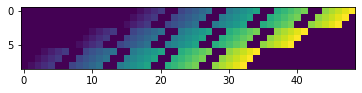

In [170]:
plt.imshow(np.stack(rotated))
plt.show()

이제 9 x 25가 아니라 9 x 49가 됐음. 이 중에 어느 column을 쓰나..? 

### Packed SISO

In [175]:
def rotate_input2(img, kernel_size):
    assert img.ndim == 2
    nx, ny = img.shape
    imgarr = img.ravel()
    f_w, f_h = kernel_size
    
    rotated = []
    nrot = int((nx*ny -1)/2)
    for rr in range(-nrot, nrot+1):
        rotated.append(left_rotate(imgarr, rr))
    return rotated

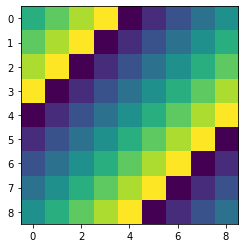

In [176]:
# 딱 9칸짜리 ctxt라고 일단... 가정 
nx = ny = 3
img = np.arange(nx * ny).reshape(nx,ny)
rotated = rotate_input2(img, (3,3))
plt.imshow(np.stack(rotated))


In [188]:
kernel = np.arange(3,12).reshape(3,3)

kernels = []

fhw = int((f_w-1)/2)
fhh = int((f_h-1)/2)

npad = 1
padded_kernel = pad(kernel, npad)

for j in range(-fhh, fhh+1): # row
    for i in range(-fhw, fhw+1): # column
        #tmp = np.zeros((f_w, f_h))
        kernels.append(padded_kernel[npad+j:npad+j+f_h,
                                     npad+i:npad+i+f_w])
        
        #kernels.append()

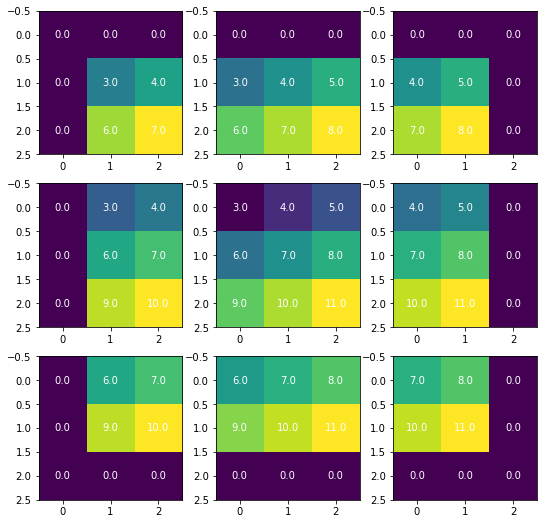

In [190]:
fig, axs = plt.subplots(3,3)
fig.set_size_inches(9,9)
axs = axs.ravel()
for ax, kk in zip(axs, kernels):
    annot_heatmap(ax, kk)

커널 준비 끝. 

In [213]:
new_img = np.zeros(nx*ny)
for rot_img, shifted_kernel in zip(rotated, kernels):
    new_img += rot_img * shifted_kernel.ravel()
    print(rot_img)
    print(shifted_kernel.ravel().astype(int))
    print(new_img.astype(int))
    print("______________\n")

[5 6 7 8 0 1 2 3 4]
[0 0 0 0 3 4 0 6 7]
[ 0  0  0  0  0  4  0 18 28]
______________

[6 7 8 0 1 2 3 4 5]
[0 0 0 3 4 5 6 7 8]
[ 0  0  0  0  4 14 18 46 68]
______________

[7 8 0 1 2 3 4 5 6]
[0 0 0 4 5 0 7 8 0]
[ 0  0  0  4 14 14 46 86 68]
______________

[8 0 1 2 3 4 5 6 7]
[ 0  3  4  0  6  7  0  9 10]
[  0   0   4   4  32  42  46 140 138]
______________

[0 1 2 3 4 5 6 7 8]
[ 3  4  5  6  7  8  9 10 11]
[  0   4  14  22  60  82 100 210 226]
______________

[1 2 3 4 5 6 7 8 0]
[ 4  5  0  7  8  0 10 11  0]
[  4  14  14  50 100  82 170 298 226]
______________

[2 3 4 5 6 7 8 0 1]
[ 0  6  7  0  9 10  0  0  0]
[  4  32  42  50 154 152 170 298 226]
______________

[3 4 5 6 7 8 0 1 2]
[ 6  7  8  9 10 11  0  0  0]
[ 22  60  82 104 224 240 170 298 226]
______________

[4 5 6 7 8 0 1 2 3]
[ 7  8  0 10 11  0  0  0  0]
[ 50 100  82 174 312 240 170 298 226]
______________



원래 이미지에 돌아간 filter를 곱하고 each i 에 대해 sum하면 맞음. 

그러지 않으려고, 이미지를 돌리고 filter도 돌린 뒤에, element-wise sum을 하면...? 

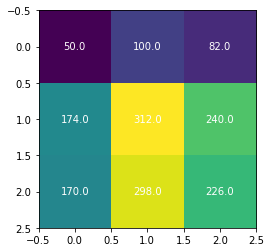

In [200]:
fig, ax = plt.subplots()

annot_heatmap(ax, new_img.reshape(3,3))
plt.show()

In [215]:
res_t = torch.conv2d(torch.tensor(img[np.newaxis, np.newaxis,:,:]), 
             torch.tensor(kernel[np.newaxis, np.newaxis,:,:]), padding=1)
img_t = res_t.squeeze().numpy()

In [216]:
img_t.reshape(3,3)

array([[ 82, 145, 106],
       [195, 312, 213],
       [130, 199, 130]])

In [202]:
kernel

array([[ 3,  4,  5],
       [ 6,  7,  8],
       [ 9, 10, 11]])

In [208]:
np.sum(np.array([4,5,7,8]) * np.array([3,4,6,7]))

130

In [16]:
import fase
from fase.core import seal_ckks
from fase.core.seal_ckks import SEALContext

# Polynomial modulus 

어떻게 결정..?

In [17]:
poly_modulus_degree = 16384
coeff_moduli = [37, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 37]

#poly_modulus_degree = 2**12
#coeff_moduli = [37] + [28] * (11) + [37]

sec = SEALContext(poly_modulus_degree=poly_modulus_degree,
                             coeff_moduli=coeff_moduli,
                             scale_bit=28)

SEAL CKKS scheme is ready


- Image is encrypted and fits in a ciphertext 
- convolution kernel is in plaintext

It's Enc_A * x, **not** W * Enc_x as in a FC layer.

In [54]:
padding = 'same'
if padding == "valid":
    # Use only valid pixels without padding
    nx_o = (nx_i - f_w + 1)/s_w
    ny_o = (ny_i - f_h + 1)/s_h
elif padding == "same":
    # pad so that the output shape doesn't change if not for stride
    nx_o = nx_i/s_w
    ny_o = ny_i/s_h
    
nx_o = int(np.floor(nx_o))
ny_o = int(np.floor(ny_o))

NameError: name 'nx_i' is not defined

- Kernel이 아니라 Input image가 encrypt되어야 하니까.. encrypt된 걸 rotate 해야함. 
- multByConst에서 0을 곱할 수는 없음. (resulting ciphertext is transparent  error 발생). 0 이면 그냥 무시. 
- 1이어도 곱하기가 필요 없겠지만 scale을 따로 관리해줘야하는 불편함이 있는 반명 CNN filter가 정확히 1이 될 경우가 거의 없을 것라 속도 향상이 작을 것으로 보로 따로 체크하지 않음. 


### rotate 전에 encrypt

문제: img pixel보다 더 많은 slot이 있기 때문에, 뒤쪽 슬롯은 전부 0임. rotate하면 0들이 앞쪽 슬롯으로 들어감.   
해결: 단순 무식한 방법-- 이미지를 두번 반복해두고 시작하기 -- 반드시 left rotate만 있어야함!  
     아니면 더 무식하게 앞, 뒤로 반복해두고 시작..

근데 이렇게 하면 두번째 convolution을 어쩌려고...? mask 씌워서 한번 걸러내면 되긴 함. 

In [15]:
img_enc = sec.encrypt(img.ravel())
img_aug = sec.add(img_enc, sec._evaluator.rotate_vector(img_enc, -nx*ny, sec.galois_keys))
sec.add(img_aug, sec._evaluator.rotate_vector(img_enc, nx*ny, sec.galois_keys), inplace=True)

NameError: name 'sec' is not defined

In [109]:
tmp = sec.decrypt(img_aug)

plt.plot(tmp)

In [72]:
# rotate

rotated_ctxt= []
for i in range(f_w):
    for j in range(f_h):
        rotated_ctxt.append(sec._evaluator.rotate_vector(img_aug, (i-1)*nx + (j-1), sec.galois_keys))
        #print((i-1)*nx + (j-1))

In [88]:
rkernel = kernel.ravel()
    
out_fhe = None
for i, rr in enumerate(rotated_ctxt):
    if rkernel[i] == 0:
        continue
    if out_fhe is None:
        out_fhe = sec.multByConst(rr, rkernel[i], broadcast=True)
    else:
        dec = sec.decrypt(rr)
        plain = np.rint(dec[:nx*ny]).astype(int)

        sec.add(out_fhe, sec.multByConst(rr, rkernel[i], broadcast=True), inplace=True)
        out_p += plain * rkernel[i]

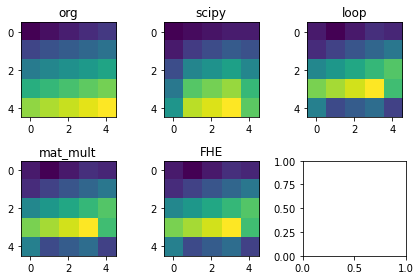

In [90]:
dec = np.rint(sec.decrypt(out_fhe)).astype(int)

res_fhe = dec[:nx*ny].reshape(nx,ny)

fig, axs = plt.subplots(2,3)
axs = axs.ravel()

axs[0].imshow(img)
axs[1].imshow(res_sc)
axs[2].imshow(out_p.reshape(nx, ny))
axs[3].imshow(out_mat.reshape(nx, ny))
axs[4].imshow(res_fhe)


axs[0].set_title("org")
axs[1].set_title("scipy")
axs[2].set_title("loop")
axs[3].set_title("mat_mult")
axs[4].set_title("FHE")


plt.tight_layout()
plt.show()

일단 돌아감... 

### convolution 결과 ctxt 모양

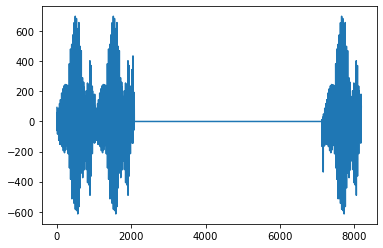

In [116]:
plt.plot(dec)

#### 함수로

In [118]:
def aug_ctxt(ctxt):
    ctxt_aug = sec.add(ctxt, sec._evaluator.rotate_vector(ctxt, -nx*ny, sec.galois_keys))
    sec.add(ctxt_aug, sec._evaluator.rotate_vector(ctxt, nx*ny, sec.galois_keys), inplace=True)
    return ctxt_aug

In [119]:
def rotate_for_conv(ctxt):
    rotated_ctxt = []
    for i in range(f_w):
        for j in range(f_h):
            rotated_ctxt.append(sec._evaluator.rotate_vector(ctxt, (i-1)*nx + (j-1), sec.galois_keys))
    return rotated_ctxt

In [123]:
def convolve_fhe(rotated_ctxt, kernel):
    rkernel = kernel.ravel()
    for i, rr in enumerate(rotated_ctxt):
#        dec = sec.decrypt(rr)
#        plain = np.rint(dec[:nx*ny]).astype(int)

        if i == 0:
            out_fhe = sec.multByConst(rr, rkernel[i], broadcast=True)
#            out_p = plain * rkernel[i]
        else:
            if rkernel[i] != 0:
                sec.add(out_fhe, sec.multByConst(rr, rkernel[i], broadcast=True), inplace=True)
#            out_p += plain * rkernel[i]
    return out_fhe

In [129]:
def conv_fhe(img_enc, kernel):
    img_aug = aug_ctxt(img_enc)
    rotated_ctxt = rotate_for_conv(img_aug)
    result = convolve_fhe(rotated_ctxt, kernel)

    return result

In [133]:
img_enc = sec.encrypt(img.ravel())
    
out_fhe_fun = conv_fhe(img_enc, kernel)

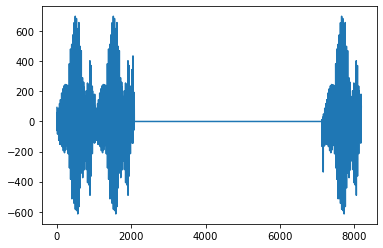

In [134]:
dec = np.rint(sec.decrypt(out_fhe_fun)).astype(int)

plt.plot(dec)

## CNN 모델

        self.conv1 = nn.Conv2d(3, 32, 3, padding=1) # padding = 0
        #self.bn1 = nn.BatchNorm2d(8)
        self.pool1 = nn.AvgPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool2 = nn.AvgPool2d(2, 2)
        
        
### 1. multi-channel
### 2. padding
### 3. stridding (== avg pool)

JoonWoo-Lee 2021

### packed SISO

### multi-channel

GAZELLE은 channel packing을 어떻게 했는가?

In [121]:
from fase.core import matrix_seal

In [118]:
import importlib

In [123]:
importlib.reload(matrix_seal)

<module 'fase.core.matrix_seal' from '/home/hoseung/Work/fhe-ai-sw-etri/fase/core/matrix_seal.py'>

In [125]:
mm = matrix_seal.Seal_matmult(sec)

In [ ]:
mm()

imag를 rotate해놨는데, kernel을 또 rotate하면서 곱한다?? 

In [126]:
from fase import seal

In [128]:
from typing import List
def matrix_multiply_diagonals(diagonals: List[seal.Plaintext], ctx: seal.Ciphertext,
                              evaluator: seal.Evaluator, galois_keys: seal.GaloisKeys):
    output = seal.Ciphertext()

    for i in range(len(diagonals)):

        temp = seal.Ciphertext()
        diagonal = diagonals[i]

        temp = evaluator.rotate_vector(ctx, i, galois_keys)

        evaluator.mod_switch_to_inplace(diagonal, temp.parms_id())
        evaluator.multiply_plain_inplace(temp, diagonal)
        evaluator.rescale_to_next_inplace(temp)

        if i == 0:
            output = temp
        else:
            evaluator.add_inplace(output, temp)

    return output


In [ ]:
tmp = seal.Ciphertext()

for img in rotated_ctxt:
    

In [ ]:
smat = Seal_matmult(sec)  

# FHE version

In [6]:
kernel_he = np.zeros(5*5, dtype=int)
kernel_he[:f_w*f_h] = kernel.ravel()

kernel_he

array([ 1,  0, -1,  2,  0, -2,  1,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0])

In [7]:
conv_repr_img = []

wx_h = f_w//2
wy_h = f_h//2

tmp = np.zeros(nx*ny, dtype=int)
for i in range(wx_h,nx-wx_h+1):
    for j in range(wy_h, ny-wy_h+1):
        tmp[:] = 0 
        tmp[:f_w*f_h] = img[i-1:i+2,j-1:j+2].ravel()
        conv_repr_img.append(tmp)

ValueError: could not broadcast input array from shape (6,) into shape (9,)

In [90]:
conv_repr_img

[array([ 0,  1,  2,  5,  6,  7, 10, 11, 12,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0]),
 array([ 1,  2,  3,  6,  7,  8, 11, 12, 13,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0]),
 array([ 2,  3,  4,  7,  8,  9, 12, 13, 14,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0]),
 array([ 5,  6,  7, 10, 11, 12, 15, 16, 17,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0]),
 array([ 6,  7,  8, 11, 12, 13, 16, 17, 18,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0]),
 array([ 7,  8,  9, 12, 13, 14, 17, 18, 19,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0]),
 array([10, 11, 12, 15, 16, 17, 20, 21, 22,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0]),
 array([11, 12, 13, 16, 17, 18, 21, 22, 23,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0]),
 array([12, 13, 14, 17, 18, 19, 22, 23, 24,  0,  0,  0, 

In [31]:
w_mat = np.stack(conv_repr_img).T

In [32]:
print(w_mat.shape, kernel.ravel())

(1024, 30) [ 1  0 -1  2  0 -2  1  0 -1]


In [33]:
res_he = np.matmul(w_mat, kernel.ravel())

res_he

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 9 is different from 30)